# Figure S2
- Information on Transcription factor genes
- TF-target network

In [5]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot

### Data directories

In [6]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

### Load and process TF data (Q: do we still need this data source or is TRRUST enough?)

In [7]:
# Load data
tf_filename = dir_genome+'human_tf.database'
tf_df0 = pd.read_csv(tf_filename, sep='\t', header=0, index_col=0)

In [8]:
# Only keep TFs
tf_df = tf_df0[tf_df0['Is TF?']=='Yes']
print('Total number of TFs = '+str(len(tf_df)))
tf_df.head()

Total number of TFs = 1639


,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,Interpro ID(s),...,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?
0,ENSG00000137203,TFAP2A,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008121;IPR013854,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False
1,ENSG00000008196,TFAP2B,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008122;IPR013854,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000008196#GO:0000981#sequence-specific...,$#ENSP00000377265#ENSG00000008196#ENST00000393...,False
2,ENSG00000087510,TFAP2C,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008123;IPR013854,...,Yes,No,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000087510#GO:0001077#RNA polymerase II...,$#ENSP00000201031#ENSG00000087510#ENST00000201...,False
3,ENSG00000008197,TFAP2D,AP-2,Yes,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,Binds the same GCCTGAGGC sequence as the other...,IPR013854;,...,Yes,No,Yes,"2a1, Lower confidence direct evidence",Arttu Jolma,Sam Lambert,Yes,$#ENSG00000008197#GO:0000981#sequence-specific...,$#ENSP00000008391#ENSG00000008197#ENST00000008...,False
4,ENSG00000116819,TFAP2E,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR013854;,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Laura Campitelli,Yes,$#ENSG00000116819#GO:0000981#sequence-specific...,$#ENSP00000362332#ENSG00000116819#ENST00000373...,False


### Load TRRUST TF-target network

In [9]:
# Load TRRUST
trrust_filename = dir_genome+'trrust_rawdata.human.tsv'
trrust_df = pd.read_csv(trrust_filename, sep='\t', header=None)
trrust_df.columns = ['TF','Target','Regulation','PMID']
print('Total number of links in raw data = '+str(len(trrust_df)))
print('Total number of unique TFs = '+str(len(np.unique(trrust_df['TF'].values))))
print('Total number of unique targets = '+str(len(np.unique(trrust_df['Target'].values))))

Total number of links in raw data = 9396
Total number of unique TFs = 795
Total number of unique targets = 2492


In [10]:
# Drop duplicates
trrust_df = trrust_df.drop_duplicates(subset=['TF','Target','Regulation'])
print('Total number of links in raw data = '+str(len(trrust_df)))
print('Total number of unique TFs = '+str(len(np.unique(trrust_df['TF'].values))))
print('Total number of unique targets = '+str(len(np.unique(trrust_df['Target'].values))))

Total number of links in raw data = 9384
Total number of unique TFs = 795
Total number of unique targets = 2492


In [11]:
# If contradictory regulation mode, label regulation mode as “Both”, and drop duplicates
trrust_df = trrust_df.sort_values(by=['TF','Regulation'])
trrust_df = trrust_df.groupby(['TF','Target'])
trrust_df = trrust_df.agg({'Regulation': lambda x: '_'.join(x), 'PMID': lambda x: ';'.join(x)})
trrust_df = trrust_df.reset_index()
print('Total number of links in raw data = '+str(len(trrust_df)))
print('Total number of unique TFs = '+str(len(np.unique(trrust_df['TF'].values))))
print('Total number of unique targets = '+str(len(np.unique(trrust_df['Target'].values))))

Total number of links in raw data = 8427
Total number of unique TFs = 795
Total number of unique targets = 2492


In [15]:
# Save processed dataframe to pickle
pickle.dump(trrust_df, open(dir_genome+'trrust_df.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
trrust_df.head()

,TF,Target,Regulation,PMID
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788


(array(['Activation', 'Activation_Repression',
       'Activation_Repression_Unknown', 'Activation_Unknown',
       'Repression', 'Repression_Unknown', 'Unknown'], dtype=object), array([2433,   95,  112,  504, 1581,  134, 3568]))


<Figure size 432x288 with 0 Axes>

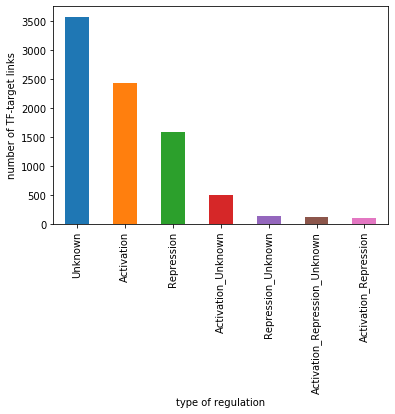

In [14]:
# Types of regulations
print(np.unique(trrust_df['Regulation'].values, return_counts=True))
plt.figure()
trrust_df.groupby('Regulation').count().reset_index().sort_values(by='PMID', ascending=False).plot.bar(x='Regulation', y='PMID', legend=None)
plt.xlabel('type of regulation')
plt.ylabel('number of TF-target links')
plt.show()

In [18]:
# Create TF-target network from edge list
tf_target_net = nx.from_pandas_edgelist(trrust_df, 'TF', 'Target', ['Regulation','PMID'], create_using=nx.DiGraph)
# Save network to html
oi.output_networkx_graph_as_interactive_html(tf_target_net, filename=saving_dir+"tf_target_net.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/tf_target_net.html')